In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import random
from collections import Counter 
import statistics
import time

### Importing and exploring data 

In [2]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [3]:
dataset.columns=['Index','Source','Target']

In [4]:
# check if index columns has unique values
print(len(dataset.Index))
print(len(set(dataset.Index)))

483094
483094


In [5]:
dataset.set_index('Index' , inplace = True)
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


#### Associate single category to each node

In [6]:
# all nodes in and out
unique_nodes = set(set(dataset.Source).union(set(dataset.Target)))
n_nodes = len(unique_nodes)
n_edges = len(dataset)

In [7]:
category_file = 'wiki-topcats-categories.txt'

Non filtered categories

In [8]:
categories_all = {v: [] for v in unique_nodes}
no_category = []

with open(category_file) as file:
    for i in range(17364):
        line = file.readline()
        category = line.split(';')[0].split(':')[-1]
        nodes = line.split(';')[1].split(' ')[1:-2]
        
        for node in nodes:
            try:
                categories_all[int(node)].append(category)
            except:
                no_category.append(int(node))

Each node is associated to its unique category

In [9]:
nodes_category = {}
for n in categories_all.keys():
    try:
        rand_category = random.choice(categories_all[n])
        nodes_category[n] = rand_category
    except:
        nodes_category[n] = None

Each category is associated to a set of nodes

In [10]:
category_nodes = {category:[] for category in set(nodes_category.values())}
for node in nodes_category.keys():
    try:
        category_nodes[nodes_category[node]].append(node)
    except:
        continue

#### Create graph

In [11]:
in_links = {v: [] for v in set(dataset.Source)}
out_links = {v: [] for v in set(dataset.Target)}

for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_links[source].append(target)
    out_links[target].append(source)

In [12]:
n_art_outlink = len(out_links)
n_art_inlink = len(in_links)

#### Check if directed

In [13]:
directed = False
for node in in_links:
    if len(set(in_links[node]).intersection(set(out_links[node]))) != 0:
        directed = True
        break
if directed:
    print('Graph is directed')
else:
    print('Graph is undirected')

Graph is directed


In [14]:
# undirected version of the graph
links = in_links.copy()
links.update(out_links)

#### Density

In [15]:
density = (n_edges/(n_nodes*(n_nodes-1)))
avarage = n_edges/n_nodes

print('Graph density is:',density)
print('Graph hyperliks avarage is:',avarage)

Graph density is: 4.9951571365597335e-05
Graph hyperliks avarage is: 4.912337431235573


#### Visualize the nodes' degree distribution

In [16]:
my_len = [] 
for node in links.keys():
    my_len.append(len(links[node]))

# dictionary with degree
node_degree = dict(zip(links.keys(), my_len))
d = Counter(node_degree)

In [17]:
# degree distribution
counter_supp = list()
for i in range(1, max(my_len)):
    counter_supp.append(my_len.count(i))

In [18]:
# cumulative degree ditribution
counter = [0]
for i in range(1, max(my_len)):
    counter.append(counter[-1]+my_len.count(i))

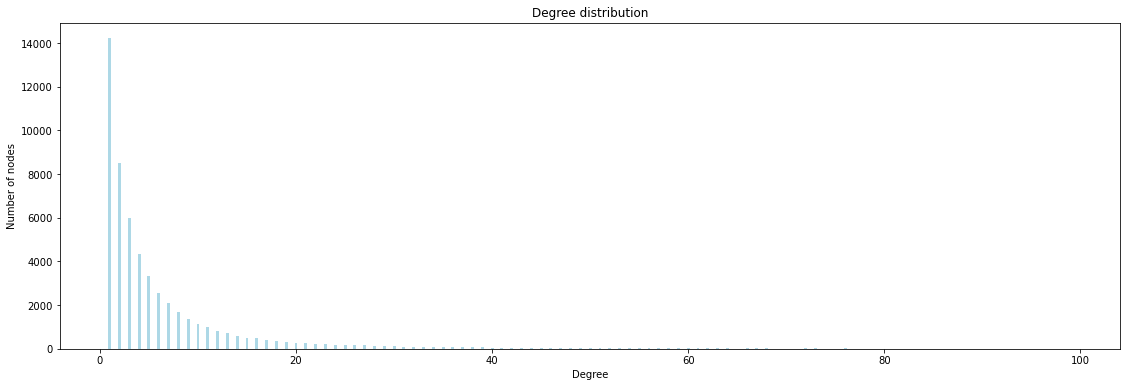

In [19]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter_supp[1:100])+1)),height = counter_supp[1:100],color = 'lightblue',width = 0.3);
#plt.plot(counter[1:100],color = 'lightblue');
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Degree distribution')
plt.show()

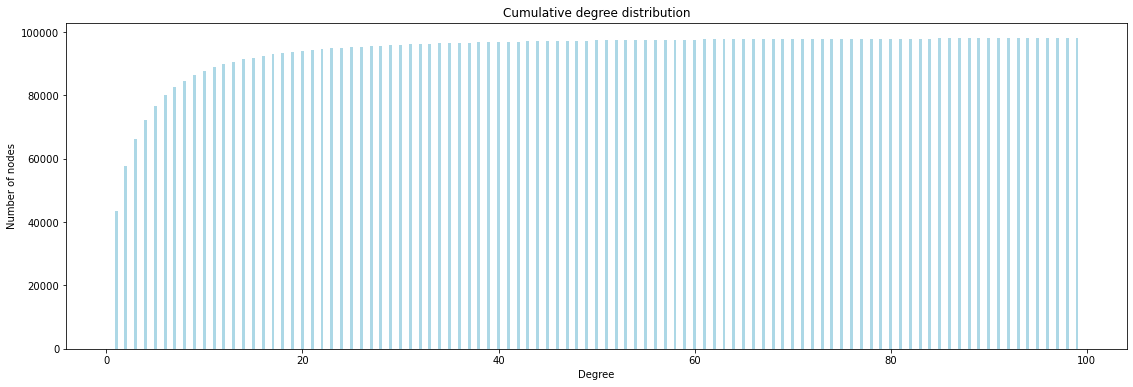

In [20]:
plt.figure(figsize = (19,6))
plt.bar(x = list(range(1,len(counter[1:100])+1)),height = counter[1:100],color = 'lightblue',width = 0.3);
#plt.plot(counter[1:100],color = 'lightblue');
plt.ylabel('Number of nodes')
plt.xlabel('Degree')
plt.title('Cumulative degree distribution')
plt.show()

### Useful Functions

In [21]:
def shortest_path (node1,node2):
    
    ''' This function takes in input two nodes and returns the length of the shortest path.
    If node 1 does not have any outlink or if no path is found between node 1 and node 2, None is returned. '''
    
    # exeptions
    if node1 == node2:
        return 0
    
    # set of outnodes of node 1
    try:
        out_nodes = set(out_links[node1]) 
    except:
        print('No out-link from', node1)
        return None
    
    # initializing explored nodes set and minimu distance
    explored = set() 
    clicks = 1
    
    ''' ITERATIONS
    1. we iterate until we find node 2 
    2. we check the new set of out-nodes to explore is non-empty 
    3. we iterate through unexplored nodes
    4. if the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes'''
   
    while node2 not in out_nodes: 
        
        if out_nodes != set(): 
            new_out_nodes = set() 

            for node in out_nodes:  
                try:
                    new_out_nodes = new_out_nodes.union(set(out_links[node]))
                except:
                    continue

            explored = explored.union(out_nodes)
            out_nodes = new_out_nodes.difference(explored) 
            clicks += 1 
        
        # case in which we have not found node 2 but we don't have any other node to explore
        else: 
            print('No path found')
            return None
    
    return clicks

In [22]:
def explore(node,limit):
   
    ''' This function takes as an input one node and a click limit.
    Limit can be set to None if we don't want any limit.
    The function returns a dictionary where keys are distances and values are all the nodes 
    which are at distance d (key) from the input node'''
    
    # initializing variables
    distance_tree = {}
    explored = set()
    clicks = 1 
    
    # checking if node has at list one outlink
    try:
        out_nodes = set(out_links[node])
    except:
        print('No out-link from', node)
        return distance_tree
    
    '''
    1. We iterate until the new set of out-nodes to explore is non-empty 
    2. For each iteration we only consider unexplored nodes
    3. If the node is a key in out_links, we add the set of nodes associated to it to the new set of nodes
    4. We update all variables and increase distance by one'''

    while out_nodes != set(): 
        
        if limit != None:
            if clicks > limit+1:         # We return when limit is given and reached
                return distance_tree
        
        distance_tree[clicks] = out_nodes
        new_out_nodes = set() 
        
        for node in out_nodes: 
            try:
                new_out_nodes = new_out_nodes.union(set(out_links[node])) 
            except:
                continue
        
        explored = explored.union(out_nodes) 
        out_nodes = new_out_nodes.difference(explored)
        clicks += 1 
    
    return distance_tree

In [23]:
node1 = 108
node2 = 1161925
node3 = 134

In [24]:
# esempi di shortest_path
print('The shortest path between', node3, 'and', node1, 'is', shortest_path(node3,node1))

The shortest path between 134 and 108 is 5


In [25]:
# esempio di explore
tree = explore(node3,None)
print('Exploration tree of node', node3, 'has max distance', max(tree.keys()))

Exploration tree of node 134 has max distance 15


## RQ2

In [26]:
def get_articles(node,n_clicks):
    '''This function works as the explore function defined above, but with a different output format.'''
    tree = explore(node_id,n_clicks)
    articles = []
    for d in tree.keys():
        articles+=tree[d]
    return articles

In [27]:
start = time.time()
n_clicks = 4
node_id = 134
articles = get_articles(node_id,n_clicks)
print('Execution time: ', (time.time() - start)/60, 'minutes')
print('Number of articles reached within', n_clicks, 'from node', node_id,':', len(articles))

Execution time:  0.27694315115610757 minutes
Number of articles reached within 4 from node 134 : 44717


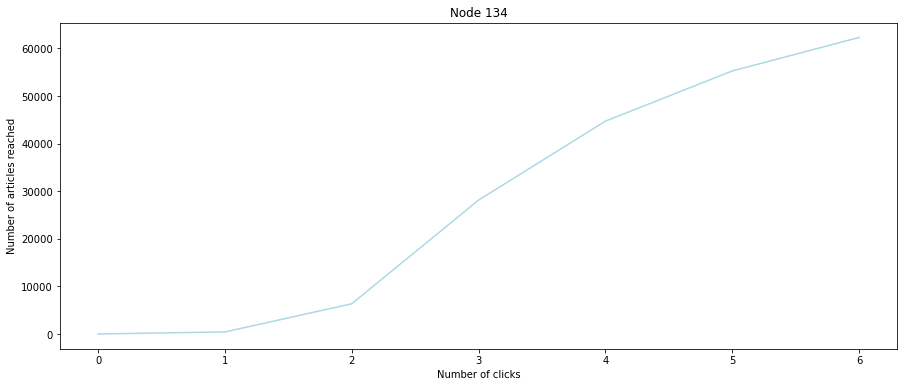

In [28]:
graph = []
for n_clicks in range(7):
    graph.append(len(get_articles(node_id,n_clicks)))
plt.figure(figsize = (15,6))
plt.plot(graph,color = 'lightblue');
plt.ylabel('Number of articles reached')
plt.xlabel('Number of clicks')
plt.title(f'Node {node_id}')
plt.show()

## RQ5

In [41]:
def categories_distance(c1):
    
    c1_nodes = [int(i) for i in category_nodes[c1]] # int casting needed for comparison
    distances_dict = {k: [] for k in category_nodes.keys()}
    
    '''
    1. We consider the exploration tree of each node in c1 with the exploration function defined above. 
    2. For each category c2 we save a list of distances between any node in c2 (node2) and node1.
    3. For a new node in c1 (node1), we will keep updating the list of distances for each category c2.
       If any node in c2 is disconnected from node1 (not in node1 tree) we consider it to be at a distance
       from equal to the max distance of node1 tree + 1.
    4. Finally, we will take the median of distances for each category and sort the dictionary.
    '''
    
    #step 1
    for node1 in c1_nodes:
        if node1 in out_links.keys():
            distance_tree = explore(node1,None)
    #step 2
            for cat in category_nodes.keys():  
                dist = []
                disconnected = []
                for node1_dist in distance_tree.keys():
                    c2_nodes = [int(i) for i in category_nodes[cat]]
                    nodes_in_tree = len(set(c2_nodes).intersection(set(distance_tree[node1_dist])))
                    dist += [node1_dist]*nodes_in_tree # number of nodes at distance d x distance d
    # step 3
                disconnected = [max(distance_tree.keys())+1]*(len(c2_nodes)-len(dist)) 
                distances_dict[cat] += dist + disconnected
    # step 4
    for key in distances_dict.keys():
        distances_dict[key] = statistics.median(distances_dict[key])
    
    distances_dict = {k: v for k, v in sorted(distances_dict.items(), key=lambda item: item[1])}
    
    return distances_dict

In [48]:
start = time.time()
d = categories_distance('Naturalised_citizens_of_the_United_Kingdom')
print('Execution time:', (time.time() - start)/60, 'minutes')

Execution time: 1.0739940524101257 minutes


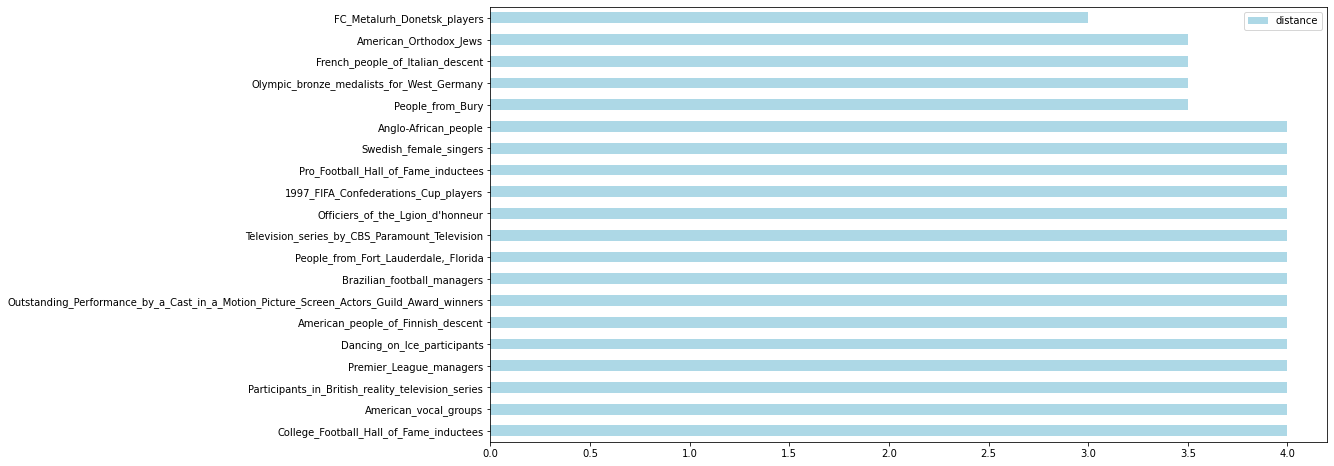

In [49]:
df_rq5 = pd.DataFrame(d, index = ['distance']).T
df_rq5.head(20).sort_values(by = 'distance', ascending = False).plot.barh(figsize = (15,8),color = 'lightblue');

In [50]:
distances = list(d.values())
dist_plot = []
for dist in set(distances):
    dist_plot.append(distances.count(dist))

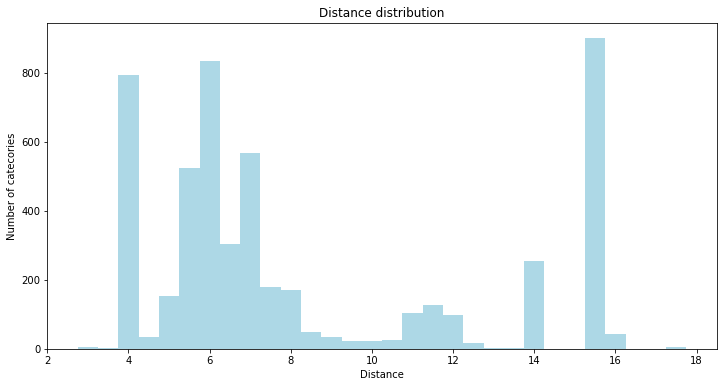

In [51]:
plt.figure(figsize=(12,6))
plt.bar(sorted(set(distances)),dist_plot,color = 'lightblue',width = 0.5);
plt.ylabel('Number of catecories')
plt.xlabel('Distance')
plt.title('Distance distribution')
plt.show()

## RQ6

In [147]:
def transform(links):
    
    ''' We transform our graph into one which has categories as nodes. 
    In order to do this we consider the inlinks and outlinks of each node separately.
    1. For each category we concatenate the nodes associated to any of the nodes of that category.
    2. We weight links by counting how many nodes in a category are linked to another node (or other nodes)
    in another category.'''
    
    links_cat = {k: [] for k in category_nodes.keys()}
    
    for node in nodes_category.keys():
        if int(node) in links.keys():
            for link in links[int(node)]:
                if link in nodes_category.keys():
                    if links_cat[nodes_category[node]] != nodes_category[link]:    # to avoid selflinks
                        links_cat[nodes_category[node]].append(nodes_category[link])

    for cat in links_cat.keys():
        categories = {}
        to_transform = set(links_cat[cat])
        for node in to_transform:
            categories[node] = links_cat[cat].count(node)
        links_cat[cat] = categories
                                     
    return links_cat

In [148]:
in_links_cat = transform(in_links)
out_links_cat = transform(out_links)

In [149]:
in_links_cat['American_military_personnel_from_Wisconsin']

{'Brooklyn_Dodgers_players': 1,
 'Baseball_players_from_Virginia': 1,
 'Living_people': 1,
 'Major_League_Baseball_pitchers': 2,
 'Minneapolis_Millers_(baseball)_players': 1,
 'Baseball_players_from_Missouri': 1,
 'Boston_Red_Sox_players': 1}

In [150]:
def pagerank(n_iter):
    
    ''' INITIALIZATION
    This page rank algorithm initialize the ranking vector assuming that all pages have the same importance.
    1. we store a list of category names with fixed index that we use for the ranking vector
    2. we initalize all values as 1 / number of nodes
    '''
    categories_names = list(set(in_links_cat.keys()).union(set(out_links_cat.keys())))
    init = [1/len(categories_names)]*len(categories_names)
    
    
    ''' ITERATIONS
    1. At each iteration we initalize a new vector to store the ranking score of each node.
    2. For each node we initialize a 0 score and save the nodes (In) that have an outlink to that node (node1).
    3. For each node (node2) that has an outlink to the analyzed node (node1), we define:
        a) Probability : probability that node1 is reached through node2
        b) Rank : rank score of node2 in the previous iteration
    4. We multiply probability of node 2 by its ranking score
    5. We sum this score for all nodes in In and assign this final score to the position of node1 in the rank vector.
    6. We update init vector.
     '''
    for i in range(n_iter):
        # print(sum(init))
        new_iter = [0]*len(categories_names)
        for node1 in categories_names:
            score = 0
            pos1 = categories_names.index(node1)
            if node1 in in_links_cat.keys():        # not all nodes have in_links
                In = in_links_cat[node1]
                for node2 in In:
                    pos2 = categories_names.index(node2)
                    prob2 = out_links_cat[node2][node1]/sum(out_links_cat[node2].values())
                    rank2 = init[pos2]
                    score += rank2*prob2
            new_iter[pos1] = score
        init = new_iter
        
    return dict(zip(categories_names,init))

In [151]:
start = time.time()
rank = pagerank(6)
print('Execution time:', (time.time() - start)/60, 'minutes')

0.9999999999999674
0.9198023565184354
0.9087211056375811
0.9042959812508701
0.9009783027486077
0.8982614014709627
Execution time: 0.679294244448344 minutes


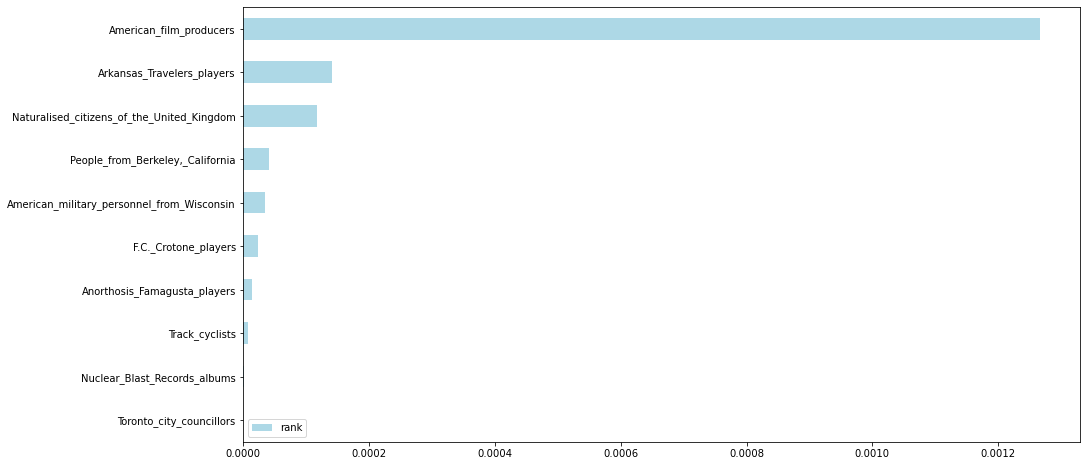

In [152]:
df_rq6 = pd.DataFrame(rank, index = ['rank']).T
df_rq6.head(10).sort_values(by = 'rank', ascending = True).plot.barh(figsize = (15,8),color = 'lightblue');